In [1]:
%reset
import numpy as np
import pandas as pd
import h5py
# f = h5py.File("dataset/Sensor_data_2kHz.h5", 'r')
f = h5py.File("F:/PhD Research/Github/agentMet4FoF/dataset/Sensor_data_2kHz.h5", 'r')

#prepare sensor data
list(f.keys())
data= f['Sensor_Data']
data= data[:,:,:data.shape[2]-1] #drop last cycle
data_inputs_np = np.zeros([data.shape[2],data.shape[1],data.shape[0]])
for i in range(data.shape[0]):
    sensor_dt = data[i].transpose()
    data_inputs_np[:,:,i] = sensor_dt

#prepare target var
target=list(np.zeros(data_inputs_np.shape[0]))          # Making the target list which takes into account number of cycles, which-
for i in range(data_inputs_np.shape[0]):                # goes from 0 to 100, and has number of elements same as number of cycles.
    target[i]=(i/(data_inputs_np.shape[0]-1))*100


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target matrix "

## Convert SI

In [3]:
#convert to SI unit
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=data_inputs_np

for i in range(data_inputs_np.shape[2]):
    sensor[:,:,i]=((data_inputs_np[:,:,i]*gain[i])+offset[i])*b[i]*k[i]

data_inputs_np = sensor

In [4]:
data_inputs_np[:,:,0]

array([[-0.05234568,  0.0136609 ,  0.08868029, ..., -0.03004555,
        -0.19048482, -0.49597595],
       [ 0.03535304,  0.06229391, -0.15793039, ..., -0.18163971,
        -0.06852667, -0.12495696],
       [ 0.15005665,  0.07379132,  0.01650666, ..., -0.2017552 ,
        -0.23651718, -0.12642235],
       ...,
       [ 0.14323738,  0.24965873, -0.37442324, ..., -0.70900728,
         0.68786802, -0.44276851],
       [ 0.02009667,  0.22807983, -0.32569662, ...,  0.91580292,
        -0.13159063, -0.61360673],
       [-0.16179621,  0.21138472,  0.11750598, ..., -0.28092648,
        -0.67483679,  0.57405284]])

## FFT BFC 

In [163]:
class FFT_BFC():
    def __init__(self,perc_feat = 10):
        """
        Parameters
        ----------
        perc_feat : int
            Percentage of features to be extracted.
            
            Optimal and recommended percentage of features for ZEMA EMC dataset is 10
        """
        
        self.fitted = False;       
        self.perc_feat = perc_feat
        self.freq_of_sorted_values = []
        
    def fit(self,x_data, perc_feat = None):
        #if perc_feat is not provided explicitly, use the internal perc_feat provided during init
        #otherwise, update the internal perc_feat to the provided one
        if perc_feat is not None:
            self.perc_feat = perc_feat
        
        #get top N% frequencies AND amplitudes N=10
        n_sensors = x_data.shape[2]
        self.n_sensors = n_sensors
        n_of_samples=x_data.shape[1]

        # Initialising the list with number of sensors
        self.freq_of_sorted_values= [0]*n_sensors

        for i in range(n_sensors):
            print("Sensor number %s" % i)
            print("---------------------------------------------------------------------------------")
            #frequency and amplitudes
            self.freq_of_sorted_values[i],__ =self.extractBFC_train(sensor = x_data[:,:,i], n_of_samples = n_of_samples, N = self.perc_feat)
        return 0     
        
    def fit_transform(self,x_data, perc_feat = None):
        """
        Gets the best `perc_feat`% of features from an array with dimensions (n_of_cycles, length_cycle, n_sensors)
        
        Parameters
        ----------
        
        x_data : np.ndarray
            Sensor measurements array with dimensions (n_of_cycles, length_cycle, n_sensors)
        
        Returns
        -------
        
        sorted_values : list of DataFrames
            len(sorted_values) == n_sensors
            DataFrame.shape == (n_of_cycles, perc_feat% * length_cycle/2) 
            
        """
        
        #if perc_feat is not provided explicitly, use the internal perc_feat provided during init
        #otherwise, update the internal perc_feat to the provided one
        if perc_feat is not None:
            self.perc_feat = perc_feat
            
        n_sensors = x_data.shape[2]
        self.n_sensors = n_sensors
        n_of_samples=x_data.shape[1]

        # Initialising the list with number of sensors
        self.freq_of_sorted_values= [0 for i in range(n_sensors)]
        sorted_values_from_all_sensors= [0 for i in range(n_sensors)]

        for i in range(n_sensors):
            print("Sensor number %s" % i)
            print("---------------------------------------------------------------------------------")
            #frequency and amplitudes
            self.freq_of_sorted_values[i],sorted_values_from_all_sensors[i]=self.extractBFC_train(sensor = x_data[:,:,i], n_of_samples = n_of_samples, N = self.perc_feat)
        return sorted_values_from_all_sensors
    
    def transform(self,x_data):
        """
        Based on the fitted values stored in get_best_frequencies(), gets the best `perc_feat`% of features from an array with dimensions (n_of_cycles, length_cycle, n_sensors)
        
        Parameters
        ----------
        
        x_data : np.ndarray
            Sensor measurements array with dimensions (n_of_cycles, length_cycle, n_sensors)
        
        Returns
        -------
        
        sorted_values : list of DataFrames
            len(sorted_values) == n_sensors
            DataFrame.shape == (n_of_cycles, perc_feat% * length_cycle/2) 
            
        """
        
        # Storing selected features from the test data into a list "sorted_values_test"
        n_sensors = x_data.shape[2]
        sorted_values_test=[0]*n_sensors
        
        for i in range(n_sensors):         
            print("Sensor number %s" % i)
            print("---------------------------------------------------------------------------------")
            sorted_values_test[i]=self.extractBFC_test(sensor_test =x_data[:,:,i], n_of_samples = n_of_samples, N = self.perc_feat, frequencies=self.get_best_frequencies()[i])
        return sorted_values_test
      
    def get_best_frequencies(self, concise=False):
        """
        Best frequencies extracted & sorted with decreasing importance via BFC. Only available after fitting to data.
        
        Parameters
        ----------
        concise : boolean (Default = False)
            Returns a ndarray version of the best frequencies if True
        
        Returns
        -------
        
        freq_of_sorted_values : list of DataFrames
            List with length of n_sensors, and each data frame is dimension of 1 x n_features
            n_features is determined by percentage of features to be obtained during initialization of params (perc_feat). 
        
        """
        
        if concise == True:
            best_f = self.freq_of_sorted_values
            best_f_np = best_f[0].values
            if len(best_f) > 1:
                for n in range(1,len(best_f)):
                    best_f_np = np.concatenate((best_f_np,best_f[n].values))
            return best_f_np
        
        else: 
            return self.freq_of_sorted_values
    
    def extractBFC_train(self,sensor, n_of_samples, N):
        sensor = sensor.transpose((1,0))
        x_measurements=range(sensor.shape[0])                 # Number of measurements samples in time period.
        x = np.true_divide(x_measurements, n_of_samples)      # Time values, used  as real time axis.
        freq = np.fft.rfftfreq(x.size, 0.0005)                # Frequency axis, can be used for ploting in frequency domain.
        fft_amplitudes = np.fft.rfft(sensor,n_of_samples,0)   # Ndarray of amplitudes after fourier transform.
        fft_matrix = pd.DataFrame(fft_amplitudes)             # Transforming amplitudes into data frame (matrix)-
                                                              # -where one column represents amplitudes of one-
                                                              # -cycle.
        fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.
        n_rows, n_columns = np.shape(fft_matrix)

        print("\nNumber of cycles is: %s, and number of features is: %s" % (n_rows, n_columns))
        fft_matrix.columns = freq                    # Column labels are frequencies.

        # Calculating the average of absolute vales for each frequency (column).
        absolute_average_values_from_columns=(np.abs(fft_matrix)).mean()

        # Sorting the fft_matrix by the average of absolute vales for each frequency (column).
        fft_matrix=fft_matrix.reindex((np.abs(fft_matrix)).mean().sort_values(ascending=False).index, axis=1)

        # Taking first N percent columns from sorted fft_matrix.
        sorted_values_matrix=fft_matrix.iloc[:,:round((N/100.0)*len(freq))]

        n_rows, n_columns = np.shape(sorted_values_matrix)
        print("\nNumber of cycles is: %s, and number of selected features is: %s" % (n_rows, n_columns))
        print(np.shape(sorted_values_matrix))

        # Informations about the selected frequencies are columns in sorted data frame.
        freq_of_sorted_values=(pd.DataFrame(sorted_values_matrix.columns)).transpose()
        print("\nFirst 10 selected frequencies are:\n\n %s" % freq_of_sorted_values.values[:,:10])

        sorted_values_matrix.columns=range(round((N/100.0)*len(freq))) # Resetting the column labels.
        print("---------------------------------------------------------------------------------\n")
        # Output "sorted_values_matrix" is data frame whose rows-
        # -are cycles and columns are selected frequencies. For example,-
        # -value at position (i,j) is amplitude for frequency j in cycle i.

        return freq_of_sorted_values, sorted_values_matrix;


    def extractBFC_test(self,sensor_test, frequencies, n_of_samples, N): 
        sensor_test = sensor_test.transpose((1,0))
        x_measurements=range(sensor_test.shape[0])            # Number of measurements in time period.
        x = np.true_divide(x_measurements, n_of_samples)      # Time values, real time axis.
        freq = np.fft.rfftfreq(x.size, 0.0005)                
        fft_amplitudes = np.fft.rfft(sensor_test,n_of_samples,0)   
        fft_matrix = pd.DataFrame(fft_amplitudes)             

        fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.

        n_rows, n_columns = np.shape(fft_matrix)

        print("\nNumber of cycles is: %s, and number of features is: %s \n" % (n_rows, n_columns))
        fft_matrix.columns = freq                    # Column labels are frequencies.

        print("Frequencies are the same as in the traning data, of course. \nFirst 10 of them:\n\n %s" % frequencies.values[:,:10])

        sorted_values_matrix_test=fft_matrix.loc[:, frequencies.loc[0,:]]

        n_rows, n_columns = np.shape(sorted_values_matrix_test)
        print("\nNumber of cycles is: %s, and number of selected features is: %s \n\n" % (n_rows, n_columns))

        sorted_values_matrix_test.columns=range(len(sorted_values_matrix_test.columns))

        return sorted_values_matrix_test;
    

In [164]:
fft_bfc = FFT_BFC()
train_transform = fft_bfc.fit_transform(data_inputs_np)
test_transform = fft_bfc.transform(data_inputs_np)

print(train_transform[0].equals(test_transform[0])) # check if they are equal

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 6291, and number of features is: 1001

Number of cycles is: 6291, and number of selected features is: 100
(6291, 100)

First 10 selected frequencies are:

 [[  0. 480.  85.   1. 640. 100.   2. 120.   3.   6.]]
---------------------------------------------------------------------------------

Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 6291, and number of features is: 1001

Number of cycles is: 6291, and number of selected features is: 100
(6291, 100)

First 10 selected frequencies are:

 [[480.  80. 479.  79.   2. 481.  78.   0.  40. 120.]]
---------------------------------------------------------------------------------

Sensor number 2
---------------------------------------------------------------------------------

Number of cycles is: 6291, and number of features is: 1001

Number of cycle


Number of cycles is: 6291, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [[240. 880. 400. 239. 241. 238. 720. 540.  60. 242.]]

Number of cycles is: 6291, and number of selected features is: 100 


True


In [169]:
fft_bfc.get_best_frequencies(concise=True)

array([[  0., 480.,  85., ..., 407.,  68.,  42.],
       [480.,  80., 479., ..., 170., 475., 865.],
       [161., 162., 120., ..., 609., 402., 167.],
       ...,
       [240., 880., 400., ..., 359., 760., 284.],
       [240., 880., 400., ..., 210., 274., 275.],
       [240., 880., 400., ..., 271., 206., 205.]])

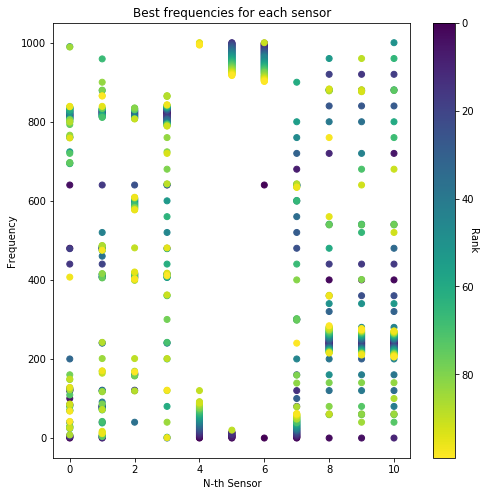

In [195]:
# plot best frequencies
import matplotlib.pyplot as plt

best_freq = fft_bfc.get_best_frequencies(concise=True)

x=[]
y=[]
c=[]

for n_sensor in range(best_freq.shape[0]):
    new_x = [n_sensor for n in range(best_freq.shape[1])]
    new_y = list(best_freq[n_sensor,:])
    new_c = list(range(best_freq.shape[1]))
    x += new_x
    y += new_y
    c += new_c

plt.figure(figsize=(8,8))
plt.scatter(x,y,c=c, cmap="viridis")
plt.title("Best frequencies for each sensor")
plt.xlabel('N-th Sensor')
plt.ylabel('Frequency')
cbar = plt.colorbar()
cbar.ax.invert_yaxis()
cbar.set_label('Rank', rotation=270)
plt.show()

## Pearson Feature Selection

In [206]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

class Pearson_FeatureSelection():
    def __init__(self):
        self.sensor_indices = sensor_indices
        self.feature_indices = feature_indices
        
    def fit(self, x_data):
        sorted_values_from_all_sensors = x_data
        n_sensors = len(sorted_values_from_all_sensors)

        n_features_for_select=0
        for i in range(len(sorted_values_from_all_sensors)):
            n_features_for_select=n_features_for_select+int(len(sorted_values_from_all_sensors[i].iloc[0][:]))

        # Defining how much of features with biggest Pearson correllation coeff. will be selected.
        # "How many features out of %s you want to select (recommended is 500): " % n_features_for_select)
        n_of_features = 500


        target_matrix = pd.DataFrame(target)        # Transforming list "target" into data frame "target_matrix"

        print("\nDimension of target matrix is:")
        print("                                                 ", target_matrix.shape)
        print("Dimension of amplitude matrix for one sensor is:")
        print("                                                 ", sorted_values_from_all_sensors[0].iloc[:][:].shape)

        corr=list(range(n_sensors))                      # Making list for correlation coefficients.
        p_value=list(range(n_sensors))

        for j in range(n_sensors):                       # Making sublists in "corr" for each sensor.
            corr[j]=list(range(round((N/100.0)*n_of_samples/2)))
            p_value[j]=list(range(round((N/100.0)*n_of_samples/2)))

        # Calculating correlation coefficients for each column of each sensor with respect to target.
        for j in range(11):
            for i in range(round((N/100.0)*n_of_samples/2)):
                corr[j][i],p_value[j][i]=pearsonr(np.abs(sorted_values_from_all_sensors[j].iloc[:][i]),target_matrix[0])
        #matrix_corr_coeff = np.transpose(pd.DataFrame(corr))# Transforming list of correlation coefficients to data frame.
        corr_array=np.array(corr)                                   # Transforming list of correlation coefficients to nparray

        print("Array of correlation coefficients has size:")
        print("                                                 ",corr_array.shape)

        def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
            """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
            flat = array.flatten()
            indices = np.argpartition(flat, -n)[-n:]
            indices = indices[np.argsort(-flat[indices])]
            return np.unravel_index(indices, array.shape)

        # sensor_indices is the index of the sensor number.
        # feature_indices is the index of the feature number for each sensor number.
        sensor_indices, feature_indices = largest_indices(corr_array, n_of_features)

        print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
        print(sensor_indices)
        print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
        print(feature_indices)
        self.sensor_indices = sensor_indices
        self.feature_indices = feature_indices
        return self
    
    def fit_transform(self,x_data):
        self.fit(x_data)
        res = self.transform(x_data)
        return res
    
    def transform(self, x_data):
        # Initialising a list of best features. 11 sublists containing features from each sensor, respectively.
        sorted_values_from_all_sensors = x_data
        n_sensors = len(sorted_values_from_all_sensors)
        top_n_features =[[] for n in range(n_sensors)]
        #NOTE: top_n_features =[[]]*int(n_sensors) doesn't work !!! 

        sensor_n = sensor_indices
        for i in range(n_sensors):
            for j in range(len(sensor_indices)):
                if sensor_indices[j]==i:
                    top_n_features[i].append(sorted_values_from_all_sensors[i].iloc[:][feature_indices[j]]);

        for i in range(n_sensors):
            for j in range(len(top_n_features[i])):
                top_n_features[i][j]=list(top_n_features[i][j])

        # Merging sublists into one list with all elements.
        top_n_together=[j for i in top_n_features for j in i]  

        top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
        print(type(top_n_together_matrix), "\n")

        # Continue working with abosulte values.
        abs_top_n_together_matrix=np.abs(top_n_together_matrix)

        percentage=list(range(n_sensors))
        k=0
        for i in range(n_sensors):
            #print(top_n_features_matrix.shape)
            print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_n)*100))
            percentage[i]=len(top_n_features[i])
            k=k+len(top_n_features[i])/len(sensor_indices)*100
        print("----------------------------------------------------")
        print("                                             %4.2f" % (k))
        
        return abs_top_n_together_matrix, percentage
    
    def plot_feature_percentages(self, sensor_percentage, labels = None, figsize=(8,8)):
        """
        Plot pie chart which shows the percentages of features from each sensor
        
        """
        fig1, ax1 = plt.subplots(figsize=figsize)
        ax1.set_title("Percentages of features from each sensor")
        ax1.pie(sensor_percentage, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, )
        ax1.axis('equal')
        plt.show()



Dimension of target matrix is:
                                                  (6291, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (6291, 100)
Array of correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: 

[ 7 10 10  8  8  2  9  0  0  1  0  7  2  3  2  2  3  9  3  1  3  5  3  3
  3  7  9  0 10  0  7  0  5  0  2  3  0  0  0  2  9  3  2  3  7  3  3  3
  0  3  0  3  3  3  3  3  0  2  0  3  3  2  2  2  0  3  3  9  0  2  0  2
  2  0  7  8 10  3  2  2  2  3  3  2  0  3  3  8  3  2  1  3  0  3  2  1
  3  0  9  3  2  3  3  0  3  0  8 10  3  3  2 10  3  2  3  3  1  0  7  0
  3  0  3  3  0  9  3  2  7  0 10  1  1 10  3  3  9  0  3  7  2  2  1  1
 10  5  2  9 10  2  7  2 10  2  2  8  2  9  2  3  2  2  2  2  7  1  2  8
  0  2 10  2  2  0  1  2  0  7  0  3  0  2  2  0  0  1  0  2  3  7  3  7
  2  2  1  0  2  2  7  0

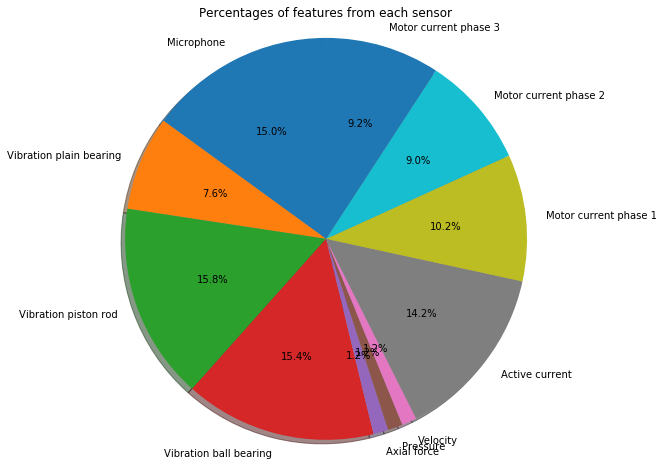

In [204]:
pearson_fs = Pearson_FeatureSelection()
abs_top_n_together_matrix , sensor_percentages = pearson_fs.fit_transform(train_transform)
#pearson_fs.transform(test_transform)

pearson_fs.plot_feature_percentages(sensor_percentages, labels = ('Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'))


In [205]:
sensor_percentage

[75, 38, 79, 77, 6, 6, 6, 71, 51, 45, 46]

## LDA Analysis

In [98]:
#LDA analysis

# Definition of new target with rounding to first higher number.
target_train_vector = target_matrix
class_target_train_vector=np.ceil(target_train_vector[0])

for i in class_target_train_vector.index:
    if class_target_train_vector[i]==0:
        class_target_train_vector[i]=1                #Fixing the zero element.

X_train = np.array(abs_top_n_together_matrix)          # Feature matrix.
y_train = np.array(class_target_train_vector)          # Target vector.

print(X_train.shape)
print(y_train.shape)


(6291, 500)
(6291,)


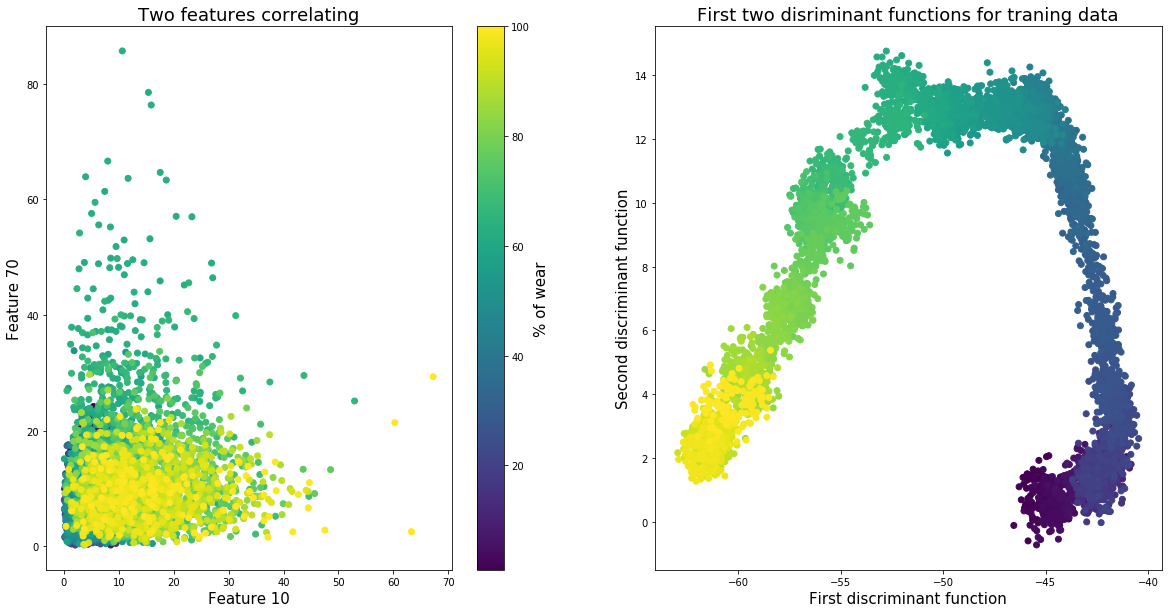

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
    
LDA1 = LinearDiscriminantAnalysis(n_components=3,priors=None, shrinkage=None, solver='eigen')

Y_train=LDA1.fit_transform(X_train,y_train)

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Two features correlating",fontsize=18)
plt.scatter(X_train[:,9], X_train[:,69], c=y_train, cmap="viridis")           
plt.xlabel("Feature 10", fontsize=15)
plt.ylabel("Feature 70", fontsize=15)
plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)

plt.subplot(122)
plt.title("First two disriminant functions for traning data",fontsize=18)
plt.scatter(Y_train[:,0], Y_train[:,1], c=y_train, cmap="viridis")                   
plt.xlabel("First discriminant function", fontsize=15)
plt.ylabel("Second discriminant function", fontsize=15)


plt.show()